# Simple resnet layer implementation
Following the implicit layers tutorial

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.profiler import profile, record_function, ProfilerActivity

import matplotlib.pyplot as plt

In [1]:
def anderson_resnet(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d, H, W = x0.shape
    X = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.linalg.solve(H[:,:n+1,:n+1], y[:,:n+1])[:, 1:n+1, 0]   # (bsz x n)

        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

In [3]:
class ResNetLayer(nn.Module):
    def __init__(self, n_channels, n_inner_channels, kernel_size=3, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_inner_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(n_inner_channels, n_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.norm1 = nn.GroupNorm(num_groups, n_inner_channels)
        self.norm2 = nn.GroupNorm(num_groups, n_channels)
        self.norm3 = nn.GroupNorm(num_groups, n_channels)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        
    def forward(self, z, x):
        y = self.norm1(F.relu(self.conv1(z)))
        return self.norm3(F.relu(z + self.norm2(x + self.conv2(y))))

In [4]:
X = torch.randn(10,64,32,32)
f = ResNetLayer(64,128)
out = anderson_resnet(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4, beta=1.0)

Text(0, 0.5, 'Relative residual')

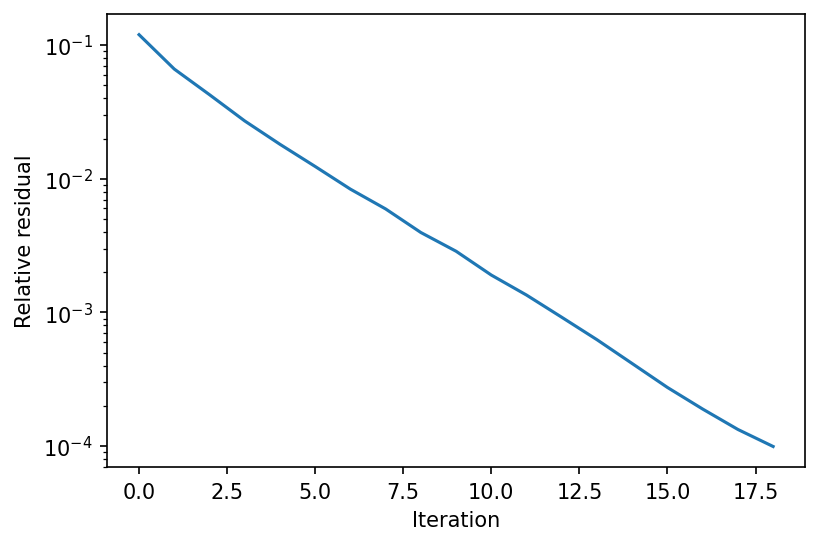

In [5]:
plt.figure(dpi=150)
plt.semilogy(out[1])
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

In [6]:
class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs

    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z,x)

        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g

        z.register_hook(backward_hook)
        return z

In [10]:
from torch.autograd import gradcheck
# run a very small network with double precision, iterating to high precision
f = ResNetLayer(2,2, num_groups=2).double()
deq = DEQFixedPoint(f, anderson_resnet, tol=1e-10, max_iter=500).double()
gradcheck(deq, torch.randn(1,2,3,3).double().requires_grad_(), eps=1e-5, atol=1e-3, check_undefined_grad=False)

True

In [16]:
f = ResNetLayer(64,128).to('cuda')
deq = DEQFixedPoint(f, anderson_resnet, tol=1e-4, max_iter=100, beta=2.0)
X = torch.randn(10,64,32,32).to('cuda')
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("forward_pass"):
        out = deq(X)
    with record_function("backward_pass"):
        (out*torch.randn_like(out)).sum().backward()

prof.export_chrome_trace("trace.json")

Text(0, 0.5, 'Residual')

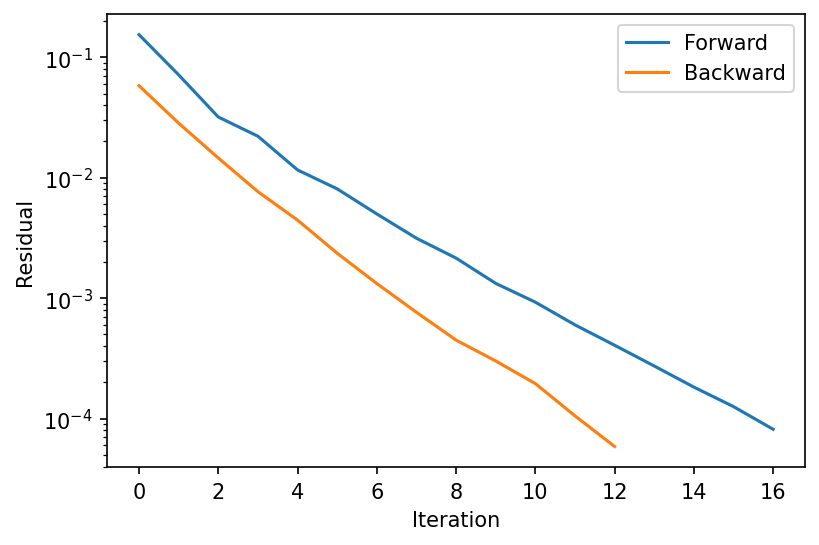

In [13]:
plt.figure(dpi=150)
plt.semilogy(deq.forward_res)
plt.semilogy(deq.backward_res)
plt.legend(['Forward', 'Backward'])
plt.xlabel("Iteration")
plt.ylabel("Residual")

# DEQLAYER
Test implementation of deq bert by using gradcheck to make sure backward pass is computed correctly.

In [2]:
from DEQBert.solvers import broyden, anderson
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from transformers.models.roberta.modeling_roberta import RobertaLayer, RobertaEmbeddings
from transformers.models.roberta.configuration_roberta import RobertaConfig
from transformers import RobertaTokenizer

import matplotlib.pyplot as plt

from typing import Optional, Tuple

C:\Users\weipy\mambaforge\envs\deqbert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialise the weights with smaller values

In [27]:
# Variant of the bertdeq layer, only change being the output dict's stored residuals is stored into self.forward/backward_res
class DEQRobertaLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = RobertaLayer(config)
        self.hook = None

        self.f_solver = broyden
        self.b_solver = broyden
        self.f_thres = 100
        self.b_thres = 100

    def residual_forward(self,
                         hidden_states: torch.Tensor,
                         initial_hidden_state: torch.Tensor,
                         attention_mask: Optional[torch.FloatTensor] = None,
                         head_mask: Optional[torch.FloatTensor] = None,
                         encoder_hidden_states: Optional[torch.FloatTensor] = None,
                         encoder_attention_mask: Optional[torch.FloatTensor] = None,
                         past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
                         output_attentions: Optional[bool] = False
                         ):
        out = list(self.layer(hidden_states, attention_mask, head_mask, encoder_hidden_states,
                   encoder_attention_mask, past_key_value, output_attentions))
        out[0] = F.layer_norm(initial_hidden_state + out[0], (self.config.hidden_size,))

        return tuple(out)

    def forward(
            self,
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.FloatTensor] = None,
            head_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
            encoder_attention_mask: Optional[torch.FloatTensor] = None,
            past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
            output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        # output of robertalayer that we want is wrapped in tuple since extra elements are provided if is_decoder=True
        f = lambda x: self.residual_forward(x, hidden_states, attention_mask, head_mask, encoder_hidden_states,encoder_attention_mask, past_key_value, output_attentions)[0]

        # initial estimate of fixed_point. Will heavily influence the output.
        z0 = torch.zeros_like(hidden_states)

        # Forward pass
        with torch.no_grad():
            out = self.f_solver(f, z0, threshold=self.f_thres)
            self.forward_out = out
            #print(f"forward out nstep: {out['nstep']}")
            z_star = out['result']
            new_z_star = z_star

        # (Prepare for) Backward pass
        if self.training:
            new_z_star = f(z_star.requires_grad_())

            def backward_hook(grad):
                if self.hook is not None:
                    self.hook.remove()
                    torch.cuda.synchronize()  # To avoid infinite recursion
                # Compute the fixed point of yJ + grad, where J=J_f is the Jacobian of f at z_star
                #print(f"new_z_star: {new_z_star.size()}, z_star: {z_star.size()}")
                out = self.b_solver(lambda y: autograd.grad(new_z_star, z_star, y, retain_graph=True)[0] + grad,
                                         torch.zeros_like(grad), threshold=self.b_thres)
                self.backward_out = out
                #print(f"backward out nstep: {out['nstep']}")
                new_grad = out['result']
                return new_grad

            self.hook = new_z_star.register_hook(backward_hook)


        #print(f"self.training {self.training}")
        #print(f"DEQ RobertaLayer forward pass hidden_states of shape {hidden_states.shape}: {hidden_states}")
        #print(f"DEQRobertaLayer z_star: {z_star}")
        #print(f"DEQRobertaLayer forward pass output: {new_z_star}")

        return (new_z_star,)

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

In [1]:
from DEQBert.modeling_deqbert import DEQBertLayer
from DEQBert.configuration_deqbert import DEQBertConfig
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
torch.manual_seed(0)

C:\Users\weipy\mambaforge\envs\deqbert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def init_weights(module):
    """ Initialize the weights """
    if isinstance(module, (nn.Linear, nn.Embedding)):
        # Slightly different from the TF version which uses truncated_normal for initialization
        # cf https://github.com/pytorch/pytorch/pull/5617
        module.weight.data.normal_(0, 0.01)
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
    if isinstance(module, nn.Linear) and module.bias is not None:
        module.bias.data.zero_()

In [3]:
config = DEQBertConfig(is_decoder=False, training=False, hidden_size=12)
layer_double = DEQBertLayer(config)
#layer_double = DEQRobertaLayer(config)
layer_double = layer_double.apply(init_weights)
layer_double = layer_double.double()
layer_double

DEQBertLayer(
  (attention): DEQBertAttention(
    (self): DEQBertSelfAttention(
      (query): Linear(in_features=12, out_features=12, bias=True)
      (key): Linear(in_features=12, out_features=12, bias=True)
      (value): Linear(in_features=12, out_features=12, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): DEQBertSelfOutput(
      (dense): Linear(in_features=12, out_features=12, bias=True)
      (LayerNorm): LayerNorm((12,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): DEQBertIntermediate(
    (dense): Linear(in_features=12, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): DEQBertOutput(
    (dense): Linear(in_features=3072, out_features=12, bias=True)
    (LayerNorm): LayerNorm((12,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (input_injection): Conv1d(12, 36, kernel_size=(1,), stride=(1,))
)

Is gradcheck supposed to take so long?

In [ ]:
from torch.autograd import gradcheck

# (batch size, seq_len, hidden_size)
input_tensor = torch.randn((1, 2, 12)).requires_grad_().double()

gradcheck(layer_double, input_tensor, eps=1e-5, atol=1e-3, check_undefined_grad=False)

Plot the residuals

In [3]:
config = DEQBertConfig(is_decoder=False, training=False)
layer = DEQBertLayer(config)
#layer = DEQRobertaLayer(config)
layer = layer.apply(init_weights)

In [4]:
input_tensor = torch.randn((1, 12, 768))
out = layer(input_tensor)[0]
(out*torch.randn_like(out)).sum().backward()

[]

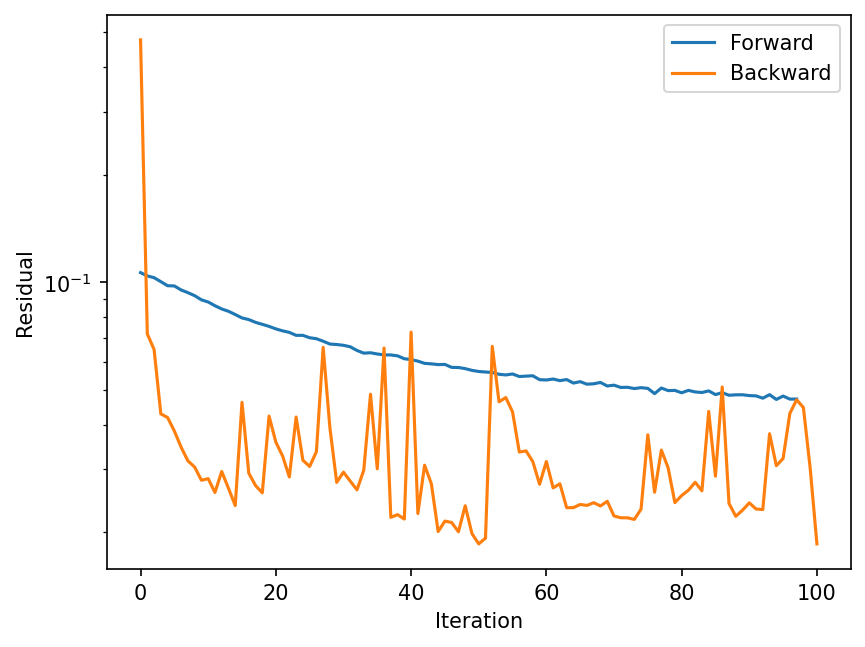

In [5]:
plt.figure(dpi=150)
plt.semilogy(layer.forward_out['rel_trace'])
plt.semilogy(layer.backward_out['rel_trace'])
plt.legend(['Forward', 'Backward'])
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.plot()

In [6]:
out

tensor([[[-0.7136,  0.9692, -0.7673,  ...,  0.2413,  0.3703,  0.9100],
         [-0.7159,  1.1391, -0.4659,  ...,  0.0855, -0.0296,  0.8198],
         [-0.8295,  1.1305, -0.6898,  ...,  0.6274,  0.3253,  0.9733],
         ...,
         [-0.6219,  1.2289, -0.8222,  ...,  0.2426, -0.0629,  0.7790],
         [-0.8656,  1.3535, -0.9328,  ...,  0.1657,  0.4170,  0.7839],
         [-0.8130,  0.9865, -0.6194,  ...,  0.2465,  0.3333,  1.1515]]],
       grad_fn=<TransposeBackward0>)

In [1]:
import torch
from DEQBert.modeling_deqbert import DEQBertModel
from DEQBert.configuration_deqbert import DEQBertConfig

In [2]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
encoded = tokenizer("What the dog doing", return_tensors='pt')
encoded

{'input_ids': tensor([[   0, 2264,    5, 2335,  608,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [2]:
inputs = {'input_ids': torch.tensor([[   0, 2264,    5, 2335,  608,    2]]), 'attention_mask': torch.tensor([[1, 1, 1, 1, 1, 1]])}
inputs

{'input_ids': tensor([[   0, 2264,    5, 2335,  608,    2]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [3]:
config = DEQBertConfig(is_decoder=False, training=False)
model = DEQBertModel.from_pretrained("models/lucas-cont/checkpoint-5000")
model

Some weights of the model checkpoint at models/lucas-cont/checkpoint-5000 were not used when initializing DEQBertModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing DEQBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DEQBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DEQBertModel were not initialized from the model checkpoint at models/lucas-cont/checkpoint-5000 and are newly initialized: ['deqbert.pooler.dense.bias', 'deqbert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

DEQBertModel(
  (embeddings): DEQBertEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): DEQBertEncoder(
    (layer): DEQBertLayer(
      (attention): DEQBertAttention(
        (self): DEQBertSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): DEQBertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
 

In [4]:
outputs = model(**inputs)
outputs

DEQBertOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.8487,  0.1493, -0.6582,  ...,  0.3026,  0.4815,  1.1537],
         [-0.3815,  0.3666, -0.5011,  ...,  0.5743,  0.5662,  1.3680],
         [-0.5125,  0.1755, -0.5368,  ...,  0.4063,  0.4601,  1.3095],
         [-0.5377,  0.0481, -0.6740,  ...,  0.4324,  0.5454,  1.2516],
         [-0.3282,  0.2894, -0.3990,  ...,  0.6292,  0.5377,  1.5422],
         [-0.4281,  0.4977,  0.0526,  ...,  0.6554,  0.6982,  1.5398]]]), pooler_output=tensor([[ 1.0525e-01,  4.1302e-01,  1.1069e-01,  1.8137e-01,  5.0700e-01,
          2.5617e-01, -7.5839e-02, -2.1175e-01,  9.6500e-02,  3.0992e-01,
         -2.9659e-01,  7.0617e-02,  2.9797e-01, -3.2878e-01,  1.2165e-01,
         -2.8744e-02, -2.6429e-01,  3.0180e-01,  1.5818e-01,  9.6477e-02,
          5.6435e-02, -3.7801e-01,  8.3478e-02, -6.0222e-02,  4.1331e-01,
          1.9213e-01, -3.2115e-01, -2.6773e-01, -3.0316e-01,  4.5143e-02,
          9.6842e-02, -8.0693e-02, -3.3486e-01, -3.0

In [9]:
for name, param in model.named_parameters():
    print(f"{name}: {param}")

embeddings.word_embeddings.weight: Parameter containing:
tensor([[ 1.3391e-02,  8.2031e-03,  1.2461e-03,  ..., -7.4719e-03,
          3.1267e-03, -1.0992e-02],
        [ 6.5783e-03, -7.7868e-03,  3.9621e-03,  ..., -5.3509e-03,
         -1.8378e-02, -8.9118e-03],
        [-7.4516e-04,  2.3479e-03,  1.3764e-02,  ...,  9.3458e-03,
         -1.3464e-02, -2.1224e-02],
        ...,
        [ 8.9008e-03, -1.2705e-02, -1.8076e-02,  ..., -1.1789e-02,
          1.1158e-02,  9.0475e-04],
        [ 1.0517e-02, -1.5456e-02, -4.3390e-04,  ...,  1.5967e-02,
          7.4998e-03,  6.5314e-05],
        [ 3.0470e-03,  1.3040e-02, -9.8449e-03,  ..., -1.8422e-03,
          1.0519e-02,  1.0407e-02]], requires_grad=True)
embeddings.position_embeddings.weight: Parameter containing:
tensor([[-0.0044, -0.0077,  0.0043,  ..., -0.0045, -0.0008,  0.0067],
        [-0.0033, -0.0091, -0.0101,  ...,  0.0047,  0.0112, -0.0027],
        [ 0.0028,  0.0002,  0.0047,  ...,  0.0155, -0.0039,  0.0126],
        ...,
       

# Testing the trained model

In [9]:
from DEQBert.modeling_deqbert import DEQBertForMaskedLM, DEQBertConfig
from DEQBert.tokenization_deqbert import DEQBertTokenizer
from transformers import pipeline

In [10]:
config_path = "DEQBert/model_card/config.json"
model_path = "models/lucas-cont-part3/checkpoint-5000"

In [11]:
# create tokenizer
tokenizer = DEQBertTokenizer.from_pretrained("roberta-base")

# create the model
model = DEQBertForMaskedLM.from_pretrained(model_path)

# create fill mask pipeline
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'DEQBertTokenizer'.


OSError: We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like models/lucas-cont-part3/checkpoint-5000 is not the path to a directory containing a config.json file.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [37]:
fill_mask("The capital of France is <mask>")

[{'score': 0.0440390408039093,
  'token': 4,
  'token_str': '.',
  'sequence': 'The capital of France is.'},
 {'score': 0.02579246461391449,
  'token': 35,
  'token_str': ':',
  'sequence': 'The capital of France is:'},
 {'score': 0.02486201748251915,
  'token': 1470,
  'token_str': ' France',
  'sequence': 'The capital of France is France'},
 {'score': 0.01926695741713047,
  'token': 5,
  'token_str': ' the',
  'sequence': 'The capital of France is the'},
 {'score': 0.018622441217303276,
  'token': 421,
  'token_str': ' expected',
  'sequence': 'The capital of France is expected'}]

## TEST

In [12]:
import numpy as np
import datasets
import wandb
from evaluate import load
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

from DEQBert.modeling_deqbert import DEQBertForMaskedLM, DEQBertForSequenceClassification, DEQBertConfig
from DEQBert.tokenization_deqbert import DEQBertTokenizer

In [35]:
# initialise the configs
config = DEQBertConfig.from_pretrained(config_path)
config.is_decoder = False

# create tokenizer
tokenizer = DEQBertTokenizer.from_pretrained("roberta-base")

# download the task splits, removing unneeded index column
dataset = datasets.load_dataset('super_glue', 'boolq')
dataset = dataset.remove_columns('idx')

# tokenize function will concatenate the inputs together with a separator token before tokenizing it.
def tokenize_function(example):
    s = []
    # each "i" is a column label
    for i in example:
        if i != 'label':
            s.append(example[i].strip())
    # have to end on SEP token, and each SEP token should have spacing between each sequence
    string = f" {tokenizer.sep_token} ".join(s)
    return tokenizer(string, padding="max_length", truncation=True)

# map across all splits of the dataset
train_dataset = dataset['train'].map(tokenize_function).with_format('torch')
valid_dataset = dataset['validation'].map(tokenize_function).with_format('torch')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'DEQBertTokenizer'.
Found cached dataset super_glue (C:/Users/weipy/.cache/huggingface/datasets/super_glue/boolq/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)
100%|██████████| 3270/3270 [00:05<00:00, 597.05ex/s]


In [36]:
tokenizer.decode(train_dataset[4]['input_ids'])

'<s>is elder scrolls online the same as skyrim </s> The Elder Scrolls Online -- As with other games in The Elder Scrolls series, the game is set on the continent of Tamriel. The events of the game occur a millennium before those of The Elder Scrolls V: Skyrim and around 800 years before The Elder Scrolls III: Morrowind and The Elder Scrolls IV: Oblivion. It has a broadly similar structure to Skyrim, with two separate conflicts progressing at the same time, one with the fate of the world in the balance, and one where the prize is supreme power on Tamriel. In The Elder Scrolls Online, the first struggle is against the Daedric Prince Molag Bal, who is attempting to meld the plane of Mundus with his realm of Coldharbour, and the second is to capture the vacant imperial throne, contested by three alliances of the mortal races. The player character has been sacrificed to Molag Bal, and Molag Bal has stolen their soul, the recovery of which is the primary game objective.</s><pad><pad><pad><pa

In [32]:
super_glue_metric = load('super_glue', 'boolq')
predictions = [0, 1]
references = [0, 1]
results = super_glue_metric.compute(predictions=predictions, references=references)

In [33]:
results

{'accuracy': 1.0}

In [28]:
tokenizer.decode(valid_dataset[0]['input_ids'])

"<s>does ethanol take more energy make that produces </s> Ethanol fuel -- All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey reports t

## Comparing the model parameter count

In [19]:
from transformers import RobertaForMaskedLM
RobertaForMaskedLM.from_pretrained("roberta-base").num_parameters()

124697433

In [18]:
model.num_parameters()

48502617

The DEQ has 1/3 the parameter count of the Roberta model.

# Profiling the model

In [6]:
from DEQBert.modeling_deqbert import DEQBertForMaskedLM
import torch
from torch.profiler import profile, record_function, ProfilerActivity

inputs = torch.tensor([[   0, 2264,    5, 2335,  608,    2]]).to("cuda")
model = DEQBertForMaskedLM.from_pretrained("Clyde013/deqbert-base").to("cuda")
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)
        
prof.export_chrome_trace("trace.json")
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
               model_inference         0.26%      12.273ms       100.00%        4.779s        4.779s       5.288ms         0.11%        4.790s        4.790s             1  
            aten::linalg_solve        32.16%        1.537s        64.47%        3.081s     118.491ms        1.508s        31.48%        3.045s     117.106ms            26  
                  aten::conv1d         0.00%       9.000us        36.03%        1.722s        1.722s       3.000us         0.00%      

In [ ]:
inputs.device

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total"))

In [38]:
print(prof.key_averages().table(sort_by="cpu_time_total"))

------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
               model_inference        17.01%      22.070ms        99.97%     129.696ms     129.696ms       5.109ms         4.91%     104.094ms     104.094ms             1  
                  aten::matmul         3.03%       3.932ms        35.79%      46.429ms     313.709us       4.772ms         4.58%      31.881ms     215.412us           148  
                  aten::linear         1.35%       1.752ms        32.59%      42.277ms     459.533us       1.217ms         1.17%      

# PUSHING THE MODEL TO HUGGINGFACE HUB

In [1]:
from DEQBert.configuration_deqbert import DEQBertConfig
from DEQBert.modeling_deqbert import DEQBertModel
from DEQBert.modeling_deqbert import DEQBertForMaskedLM

DEQBertConfig.register_for_auto_class()
DEQBertModel.register_for_auto_class("AutoModel")
DEQBertForMaskedLM.register_for_auto_class("AutoModelForMaskedLM")

deqbert = DEQBertForMaskedLM.from_pretrained("models/lucas-cont/checkpoint-5000")
deqbert.push_to_hub("deqbert-base")

Some weights of the model checkpoint at models/lucas-cont/checkpoint-5000 were not used when initializing DEQBertForMaskedLM: ['deqbert.encoder.layer.input_injection.weight', 'deqbert.encoder.layer.input_injection.bias']
- This IS expected if you are initializing DEQBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DEQBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AttributeError: 'str' object has no attribute '_create_or_get_repo'